In [7]:
import numpy as np
import math
import shap
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv('microreactor.csv')
X = df.iloc[:, list(range(29, 37))]
Y = df.iloc[:, list(range(4, 8))]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [16]:


# Define KAN symoblic function

def compute_YFLUX(inputs):
    x1, x2, x3, x4, x5, x6, x7, x8 = inputs
    return (
        -0.1292 * math.sin(5.5999 * x1 - 7.7952)
        - 0.122 * math.cos(5.6954 * x2 + 8.73)
        - 0.0549 * math.cos(6.174 * x7 + 0.9977)
        + 0.083 * math.cos(3.008 * x8 + 4.8941)
        + 0.5692
        + 0.0392 * math.exp(-40.96 * (0.7438 - x3)**2)
        - 0.1291 * math.exp(-16.0 * (0.669 - x6)**2)
        - 0.1698 * math.exp(-12.8451 * (0.5606 - x5)**2)
        - 0.1172 * math.exp(-13.256 * (0.4273 - x4)**2)
    )

#mir: I am using test data to generate SHAP values
#whatever data you have used to derive FNN SHAP values, you should use the same for KAN

#do not forget scaling
xscaler=MinMaxScaler()
x_test_scaled=xscaler.fit_transform(X_test)

# Define a wrapper function for SHAP
def model(inputs):
    # Apply the custom function to multiple samples
    return np.array([compute_YFLUX(x) for x in inputs])

#get use the scaled array for SHAP
X_samples = x_test_scaled.copy()

# Initialize KernelExplainer
#mir: try ExactExplainer if it is faster and easier to use
explainer = shap.KernelExplainer(model, X_samples[0:300])  # Use a subset of data for reference values

# Compute SHAP values for a subset of samples
shap_values = explainer.shap_values(X_samples[0:])  # Analyze all samples

#make a bar plot like FNN, use consistent naming, color, styling, and so on ....

Using 226 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 226/226 [00:46<00:00,  4.89it/s]


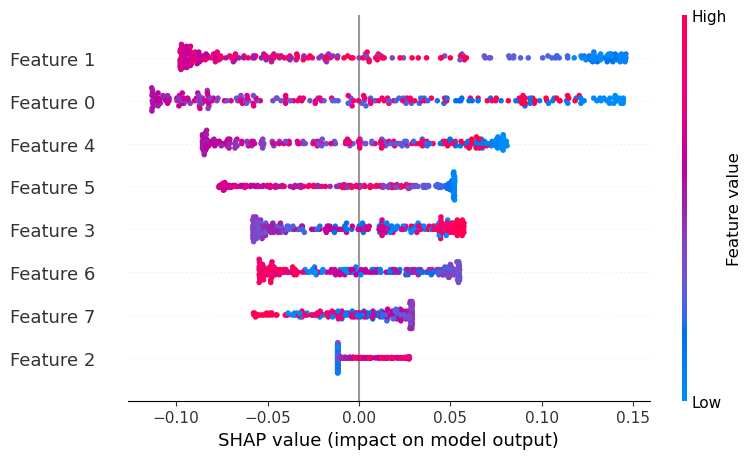

In [17]:
# Plot SHAP summary
shap.summary_plot(shap_values, X_samples[0:])

In [18]:
shap_values.mean(axis=0)

array([ 3.25452546e-18,  6.98494851e-18,  5.38838885e-18,  6.32483250e-18,
       -1.22812281e-18,  4.82038205e-18,  3.07030704e-18,  4.17561757e-18])

In [21]:
# post process shap results
feature_names = ['Theta 1', 'Theta 2', 'Theta 3', 'Theta 4', 'Theta 5', 'Theta 6', 'Theta 7', 'Theta 8']
output_names = ['Flux Q1']
shap_mean = pd.DataFrame(
    np.abs(shap_values).mean(axis=0),
    columns=output_names,
    index=feature_names,
    )
print(shap_mean)

          Flux Q1
Theta 1  0.073141
Theta 2  0.076850
Theta 3  0.012407
Theta 4  0.036814
Theta 5  0.051316
Theta 6  0.039420
Theta 7  0.034834
Theta 8  0.021192


Theta 2    0.076850
Theta 1    0.073141
Theta 5    0.051316
Theta 6    0.039420
Theta 4    0.036814
Theta 7    0.034834
Theta 8    0.021192
Theta 3    0.012407
Name: Flux Q1, dtype: float64


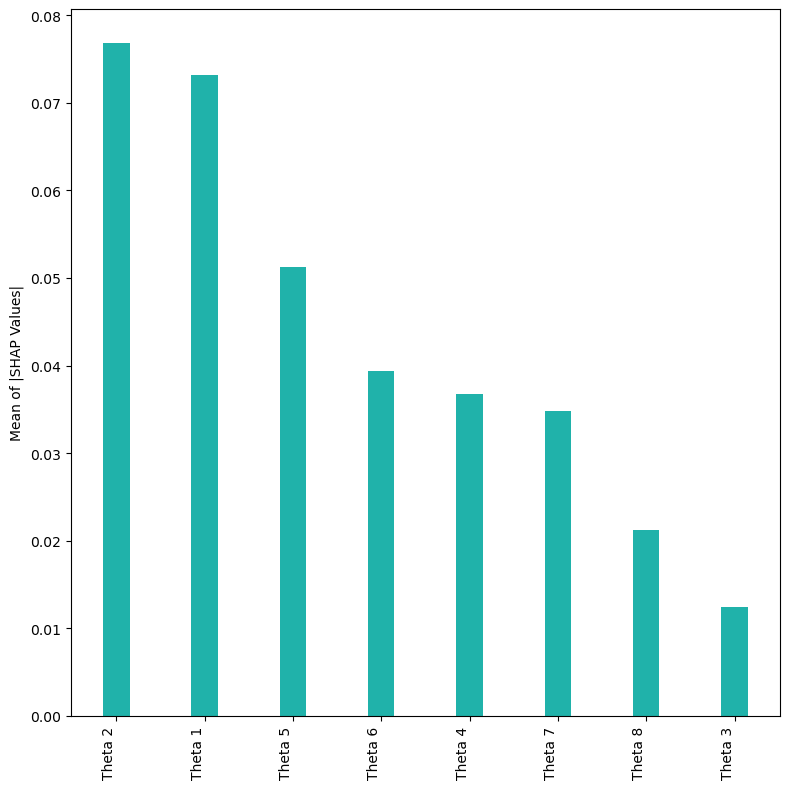

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
df_mean_sorted = shap_mean.iloc[:, 0].sort_values(ascending=False)
print(df_mean_sorted)
ax.bar(df_mean_sorted.index, df_mean_sorted.iloc[:], capsize=4, width=0.3, color="lightseagreen")
ax.set_ylabel("Mean of |SHAP Values|")
plt.xticks(rotation=90, ha="right") ## FIX THIS!
plt.tight_layout()
plt.savefig('shap_kan_htgr.png', dpi=300)